In [3]:
!pip uninstall -y jax jaxlib
!pip uninstall -y tensorflow-decision-forests tensorflow-text tf-keras

!pip install tensorflow==2.19.0

!pip install datasets==3.6.0

In [4]:
import tensorflow as tf
import scipy.fftpack as fp
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
import json

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


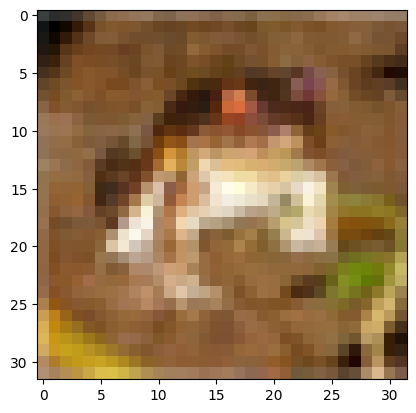

/tmp/ipython-input-2672651239.py:13: RuntimeWarning: Mean of empty slice.
  f = lambda r : processed[(R >= r-0.5) & (R < r+0.5)].mean()
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2480: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


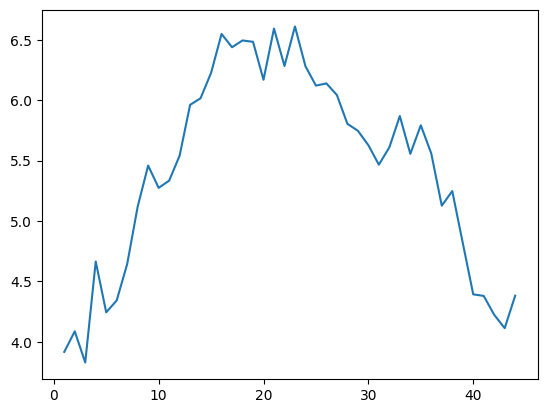

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
img = x_train[0]
plt.imshow(img)
plt.show()

transformed = fp.fft(fp.fft(img, axis=0), axis=1)
centered = fp.fftshift(transformed)
processed = np.log(abs(centered) + 1e-8)

x,y = np.meshgrid(np.arange(processed.shape[1]),np.arange(processed.shape[0]))
R = np.sqrt(x**2+y**2)

f = lambda r : processed[(R >= r-0.5) & (R < r+0.5)].mean()
r  = np.linspace(1,50,num=50)
mean = np.vectorize(f)(r)

fig,ax=plt.subplots()
ax.plot(r,mean)
plt.show()

In [ ]:
!pip install datasets==3.6.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


##Remove frequencies

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

imagenette.py: 0.00B [00:00, ?B/s]

320px/train/0000.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

320px/validation/0000.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

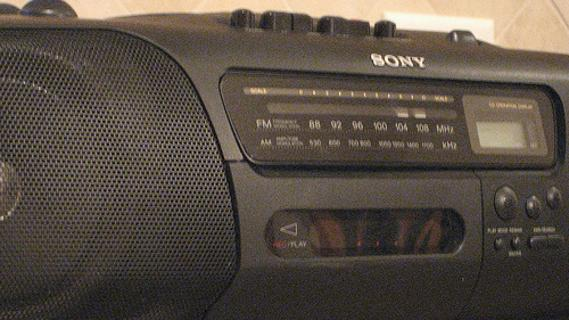

In [13]:
from datasets import load_dataset

ds = load_dataset("frgfm/imagenette", "320px")

image = ds["train"][0]["image"]
image

(426, 320)


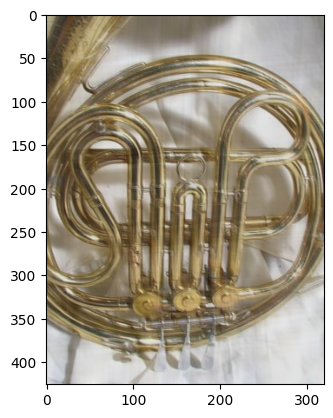

In [27]:
image_data = np.array(image)
image_red = image_data[:,:,0]
print(image_red.shape)
image_green = image_data[:,:,1]
image_blue = image_data[:,:,2]

def remove_freqs(img_data, threshold):
  image_fft = fp.fft2(img_data)

  rows, cols = img_data.shape
  freq_x = fp.fftfreq(cols)
  freq_y = fp.fftfreq(rows)

  for i in range(len(freq_x)):
    for j in range(len(freq_y)):
      if freq_x[i] > threshold and freq_y[j] > threshold:
        image_fft[i][j] = 0.0
        # image_fft[rows - i][cols - j] = 0.0
        # image_fft[rows - i][j] = 0.0
        # image_fft[i][cols - j] = 0.0

  inverse = np.real(fp.ifft2(image_fft))
  return inverse

red_inverse = remove_freqs(image_red, 0.01)
green_inverse = remove_freqs(image_green, 0.01)
blue_inverse = remove_freqs(image_blue, 0.01)
inverse = np.stack([red_inverse, green_inverse, blue_inverse], axis=2)

img_norm = (inverse - inverse.min()) / (inverse.max() - inverse.min())
plt.imshow(img_norm)

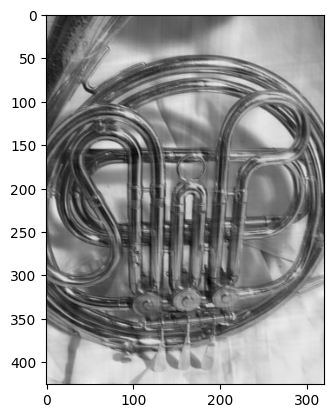

In [28]:
image_gray = np.mean(np.array(image).astype(float), axis=2)
gray_inverse = remove_freqs(image_gray, 0.01)

plt.imshow(gray_inverse, cmap='gray')
plt.show()

In [31]:
import h5py
f = h5py.File("/content/efficientnetB0_harmonized.h5", mode="r+")
model_config_string = f.attrs.get("model_config")
if model_config_string.find('"groups": 1,') != -1:
    model_config_string = model_config_string.replace('"groups": 1,', '')
    f.attrs.modify('model_config', model_config_string)
    f.flush()
    model_config_string = f.attrs.get("model_config")
    assert model_config_string.find('"groups": 1,') == -1

f.close()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/efficientnetB0_harmonized.h5', errno = 2, error message = 'No such file or directory', flags = 1, o_flags = 2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Test harmonized model

In [26]:
# Source - https://stackoverflow.com/a
# Posted by shackste, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-08, License - CC BY-SA 4.0
# for recovering corrupted .h5 models
import h5py as h5

def RecoverFile( f1, f2 ):
    """  recover read-open HDF5 file f1 to write-open HDF5 file f2  """
    names = []
    f1.visit(names.append)
    for n in names:
        try:
            f2.create_dataset( n, data=f1[n][()] )
        except:
            pass



with h5.File( "/content/vgg16_harmonized.h5", 'r' ) as fb:
    with h5.File( "/content/vgg16_harmonized_recovered.h5", 'w' ) as fr:
        for key in fb.keys():
            try:
                fr.create_dataset( key, data=fb[key][()] )
            except:
                try:
                    fr.create_group(key)
                    RecoverFile( fb[key], fr[key] )
                except:
                    fr.__delitem__(key)

OSError: Unable to synchronously open file (truncated file: eof = 259882965, sblock->base_addr = 0, stored_eof = 1106996760)

In [36]:
!wget https://storage.googleapis.com/serrelab/prj_harmonization/models/vgg16_harmonized.h5 -O vgg16_harmonized.h5

model = tf.keras.models.load_model("vgg16_harmonized.h5")

--2025-12-08 19:46:25--  https://storage.googleapis.com/serrelab/prj_harmonization/models/vgg16_harmonized.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.207, 173.194.217.207, 142.251.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1106996760 (1.0G) [application/octet-stream]
Saving to: ‘vgg16_harmonized.h5’

vgg16_harmonized.h5 100%[===================>]   1.03G  27.7MB/s    in 19s     

2025-12-08 19:46:45 (54.2 MB/s) - ‘vgg16_harmonized.h5’ saved [1106996760/1106996760]



In [33]:
!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-dog-royalty-free-image-505534037-1565105327.jpg -O sample_image.jpg

!gdown 13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj

--2025-12-08 19:43:42--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-dog-royalty-free-image-505534037-1565105327.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541440 (529K) [image/jpeg]
Saving to: ‘sample_image.jpg’

sample_image.jpg    100%[===================>] 528.75K  --.-KB/s    in 0.04s   

2025-12-08 19:43:42 (11.8 MB/s) - ‘sample_image.jpg’ saved [541440/541440]

Downloading...
From: https://drive.google.com/uc?id=13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj
To: /content/imagenet_classes.json
100% 32.6k/32.6k [00:00<00:00, 62.5MB/s]


In [34]:
#make sure running on gpu
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

#import VGG19 model
vgg16 = models.vgg16(weights="IMAGENET1K_V1").to(device)
vgg16.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
#assess VGG16 on Imagenette
labels_imagenette = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
imagenette_indices = [0, 217, 482, 491, 497, 566, 569, 571, 574, 701]

preprocess_im = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

#function specific for unharmonized model
def model_pred(outputs, class_labels):

  outputs_imagenette_specific = outputs[0, imagenette_indices]
  compute = F.softmax(outputs_imagenette_specific, dim=0)
  probability, predicted_class = torch.max(compute, dim=0)
  return str(labels_imagenette[predicted_class.item()])

def load_preprocess(img):
  image_tensor = preprocess_im(img)
  image_tensor.unsqueeze_(0)
  return image_tensor




In [107]:

#function for decoding for harmonized model
def decode_preds(outputs, class_names):
  # Assuming outputs is the tensor of model outputs
  outputs_imagenette_specific = outputs[0, imagenette_indices]
  softmax_outputs = np.exp(outputs_imagenette_specific) / np.sum(np.exp(outputs), axis=1, keepdims=True)
  softmax_outputs = torch.from_numpy(softmax_outputs)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)

  predicted_class_labels = [class_names[idx] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()
  return predicted_class_labels


In [20]:
# clean the dataset to remove greyscale images
def clean_data(dataset):
  new_ds = []
  for i in range(len(dataset)):
    image = dataset['validation'][i]["image"]
    image_data = np.array(image)
    if len(image_data.shape) == 3:
      new_ds.append(dataset[i])
  return new_ds


In [21]:

from datasets import load_dataset, DatasetDict, Dataset

new_ds = DatasetDict({
    'train': [],
    'validation': [],
})
for i in range(len(ds['validation'])):
  data = ds['validation'][i]
  image = data["image"]
  image_data = np.array(image)
  if len(image_data.shape) == 3:
    new_ds["validation"].append(data)
Dataset.from_list(new_ds["train"])
Dataset.from_list(new_ds["validation"])
print(type(new_ds["validation"][0]))





<class 'dict'>


In [82]:
#This shows how many grayscale images are filtered out
print('Number of grayscale images filtered out: ' + str(len(ds["validation"]) - len(new_ds["validation"])))


Number of grayscale images filtered out: 69


In [45]:

#testing vgg16 on all filtered images in validation
vgg16.eval()


correct = 0

for i in range(len(new_ds["validation"])):
  ground_truth = labels_imagenette[new_ds["validation"][i]["label"]]
  im = load_preprocess(new_ds["validation"][i]["image"]).to(device)
  with torch.no_grad():
    output= vgg16(im)
  model_pred(output, labels_imagenette)
  predicted_label = model_pred(output, labels_imagenette)

  if predicted_label == ground_truth:
    correct += 1

accuracy = correct/len(new_ds["validation"])

final_acc = accuracy * 100
print(final_acc)


KeyboardInterrupt: 

In [81]:
#testing harmonized vgg16 on 1 filtered images in validation

vgg16.eval()


correct = 0

for i in range(1):
  ground_truth = labels_imagenette[new_ds["validation"][3000]["label"]]
  im = load_preprocess(new_ds["validation"][3000]["image"]).to(device)
  with torch.no_grad():
    output= vgg16(im)
  model_pred(output, labels_imagenette)
  predicted_label = model_pred(output, labels_imagenette)
  print(predicted_label)
  if predicted_label == ground_truth:
    correct += 1

accuracy = correct/1

final_acc = accuracy * 100
print(final_acc)


golf ball
100.0


In [102]:

#testing harmonized vgg16 on all filtered images in validation

correct = 0

for i in range(len(new_ds["validation"])):
  ground_truth = labels_imagenette[new_ds["validation"][i]["label"]]
  img_preprocessed = preprocess_im(new_ds["validation"][i]["image"]).permute(1, 2, 0).unsqueeze(0)
  out = model.predict(img_preprocessed)
  predicted_labels = decode_preds(out,labels_imagenette)
  if predicted_labels[0] == ground_truth:
    correct += 1

accuracy = correct/1

final_acc = accuracy * 100
print(final_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
chain saw
chain saw
100.0


In [106]:

#testing harmonized vgg16 on 1 filtered images in validation
correct = 0

for i in range(1):
  ground_truth = labels_imagenette[new_ds["validation"][12]["label"]]
  img_preprocessed = preprocess_im(new_ds["validation"][12]["image"]).permute(1, 2, 0).unsqueeze(0)
  out = model.predict(img_preprocessed)
  predicted_labels = decode_preds(out,labels_imagenette)
  if predicted_labels[0] == ground_truth:
    correct += 1

accuracy = correct/1

final_acc = accuracy * 100
print(final_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
100.0
